# Sentio Model Training
#### (for testing outside application)

Training notebook for mental health text classification models.

**Available models:**
- `logistic_regression` - Fast baseline, good for quick iteration
- `random_forest` - Ensemble baseline
- `lstm` - Bidirectional LSTM neural network
- `transformer` - Custom transformer encoder (no pretrained weights)

## Set paths based on if running locally or in Google Colab

In [ ]:
# Author: Marcus Berggren
import sys
from pathlib import Path
import nltk
from ml_pipeline.preprocessing.preprocessor import DataPreprocessingPipeline

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

preprocessor = DataPreprocessingPipeline()

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # If you are using Google colab, upload both 'sentio/data/' and 'sentio/ml_pipeline' folders to Colab Notebooks folder on Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = Path('/content/drive/MyDrive/Colab Notebooks')
else:
    PROJECT_ROOT = Path.cwd().parent.parent

sys.path.insert(0, str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'ml_pipeline' / 'sentio_results' / 'increment'

print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"Data dir: {DATA_DIR}")
print(f"Output dir: {OUTPUT_DIR}")

[nltk_data] Downloading package punkt_tab to /home/mbx/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/mbx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mbx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mbx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mbx/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2025-12-02 02:23:32,609 - ml_pipeline.preprocessing.preprocessor - INFO - Downloading NLTK resource: stopwords
2025-12-02 02:23:32,610 - ml_pipeline.preprocessing.preprocessor - INFO - Downloading NLTK resource: wordnet
2025-12-02 02:23:32,611 - ml_pipeline.preprocessing.preprocessor - INFO - Downloading NLTK resource: omw-1.4


Environment: Local
Data dir: /home/mbx/Documents/projects/gitlab/sentio/data
Output dir: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment


In [2]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    force=True # Should enforce logs to show
)

## Configuration

**Change `MODEL_TYPE` to train different models.**

In [3]:
# MODEL SELECTION
# Options: 'logistic_regression', 'random_forest', 'lstm', 'transformer'
MODEL_TYPE = 'random_forest'

# TRAINING CONFIG
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Model-specific configs
MODEL_CONFIGS = {
    'logistic_regression': {
        'max_iter': 1000,
        'C': 1.0,
    },
    'random_forest': {
        'n_estimators': 100,
        'max_depth': None,
        'tfidf': {
            'max_features': 10000,
        },
    },
    'lstm': {
        'embed_dim': 128,
        'hidden_dim': 128,
        'num_layers': 2,
        'dropout': 0.2,
        'epochs': 7,
        'patience':3,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'max_seq_len': 256,
        'vocab_size': 30000,
    },
    'transformer': {
    'd_model': 256,
    'nhead': 8,
    'num_layers': 2,
    'dim_feedforward': 256,
    'dropout': 0.1,
    'epochs': 15,
    'patience': 3,
    'batch_size': 32,
    'learning_rate': 1e-5,
    'max_seq_len': 256,
    'vocab_size': 30000,
}
}

print(f'Model: {MODEL_TYPE}')
print(f'Output: {OUTPUT_DIR}')

Model: random_forest
Output: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment


## Load and Prepare Data

In [4]:
import pandas as pd

# Make sure you have the following csv files in 'sentio/data/' folder. In Django application data is taken from db.

df_train = pd.read_csv(f'{DATA_DIR}/sentio-data-train.csv')
X_train = df_train['text_preprocessed']
y_train = df_train['label']

df_test = pd.read_csv(f'{DATA_DIR}/sentio-data-test.csv')
X_test_fixed = df_test['text_preprocessed']
y_test_fixed = df_test['label']

df_incremental = pd.read_csv(f'{DATA_DIR}/sentio-data-increment.csv')
X_train_incremental = df_incremental['text_preprocessed']
y_train_incremental = df_incremental['label']


In [5]:
import numpy as np

print(f'Train: {len(X_train):,} samples')
print('Train label distribution:')
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f'  {label}: {count:,} ({count/len(y_train)*100:.1f}%)')

print()
print(f'Test: {len(X_test_fixed):,} samples')
print('Test label distribution:')
unique, counts = np.unique(y_test_fixed, return_counts=True)
for label, count in zip(unique, counts):
    print(f'  {label}: {count:,} ({count/len(y_train)*100:.1f}%)')

print()
print(f'Incremental: {len(X_train_incremental):,} samples')
print('Incremental label distribution:')
unique, counts = np.unique(y_train_incremental, return_counts=True)
for label, count in zip(unique, counts):
    print(f'  {label}: {count:,} ({count/len(y_train)*100:.1f}%)')

Train: 35,968 samples
Train label distribution:
  Depression: 11,413 (31.7%)
  Normal: 9,681 (26.9%)
  Stress: 7,002 (19.5%)
  Suicidal: 7,872 (21.9%)

Test: 8,992 samples
Test label distribution:
  Depression: 2,853 (7.9%)
  Normal: 2,420 (6.7%)
  Stress: 1,751 (4.9%)
  Suicidal: 1,968 (5.5%)

Incremental: 3,000 samples
Incremental label distribution:
  Depression: 750 (2.1%)
  Normal: 750 (2.1%)
  Stress: 750 (2.1%)
  Suicidal: 750 (2.1%)


## Train Model

In [6]:
from ml_pipeline.training.trainer import ModelTrainer
from ml_pipeline.storage.handler import StorageHandler
from datetime import datetime

storage = StorageHandler(OUTPUT_DIR)
trainer = ModelTrainer(storage)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
job_id = f'{MODEL_TYPE}_{timestamp}'

print(f'Job ID: {job_id}')
print(f'Device: {trainer.device}')

2025-12-02 02:08:49,012 - ml_pipeline.training.trainer - INFO - Initialized ModelTrainer with device: cpu


Job ID: random_forest_20251202_020849
Device: cpu


In [7]:
config = MODEL_CONFIGS.get(MODEL_TYPE, {})
print(f'Config for {MODEL_TYPE}:')
for key, value in config.items():
    print(f'  {key}: {value}')

Config for random_forest:
  n_estimators: 100
  max_depth: None
  tfidf: {'max_features': 10000}


In [8]:
%%time
print(f'Training {MODEL_TYPE}...')

result = trainer.train(
    model_name=MODEL_TYPE,
    data=(X_train, y_train, X_test_fixed, y_test_fixed),
    config=config,
    job_id=job_id,
)

print('Training complete!')

2025-12-02 02:08:49,027 - ml_pipeline.training.trainer - INFO - Starting training for random_forest
2025-12-02 02:08:49,027 - ml_pipeline.training.trainer - INFO - Training on 35968 samples


Training random_forest...


2025-12-02 02:09:07,653 - ml_pipeline.training.trainer - INFO - Evaluating on 8992 samples
2025-12-02 02:09:08,673 - ml_pipeline.evaluation.evaluator - INFO - Top 10 features:
2025-12-02 02:09:10,574 - ml_pipeline.storage.handler - INFO - Saved sklearn model to /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_random_forest_20251202_020849.joblib
2025-12-02 02:09:10,575 - ml_pipeline.training.trainer - INFO - Training complete. Accuracy: 0.7234


Training complete!
CPU times: user 2min 22s, sys: 818 ms, total: 2min 23s
Wall time: 21.6 s


## Results

In [9]:
print(f"Status: {result['status']}")
print(f"Model: {result['model_type']}")
print(f"Path: {result['model_path']}")
print("Metrics:")
print(f"  Accuracy:  {result['metrics']['accuracy']:.4f}")
print(f"  Precision: {result['metrics']['precision']:.4f}")
print(f"  Recall:    {result['metrics']['recall']:.4f}")
print(f"  F1 Score:  {result['metrics']['f1_score']:.4f}")

Status: success
Model: random_forest
Path: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_random_forest_20251202_020849.joblib
Metrics:
  Accuracy:  0.7234
  Precision: 0.7235
  Recall:    0.7234
  F1 Score:  0.7191


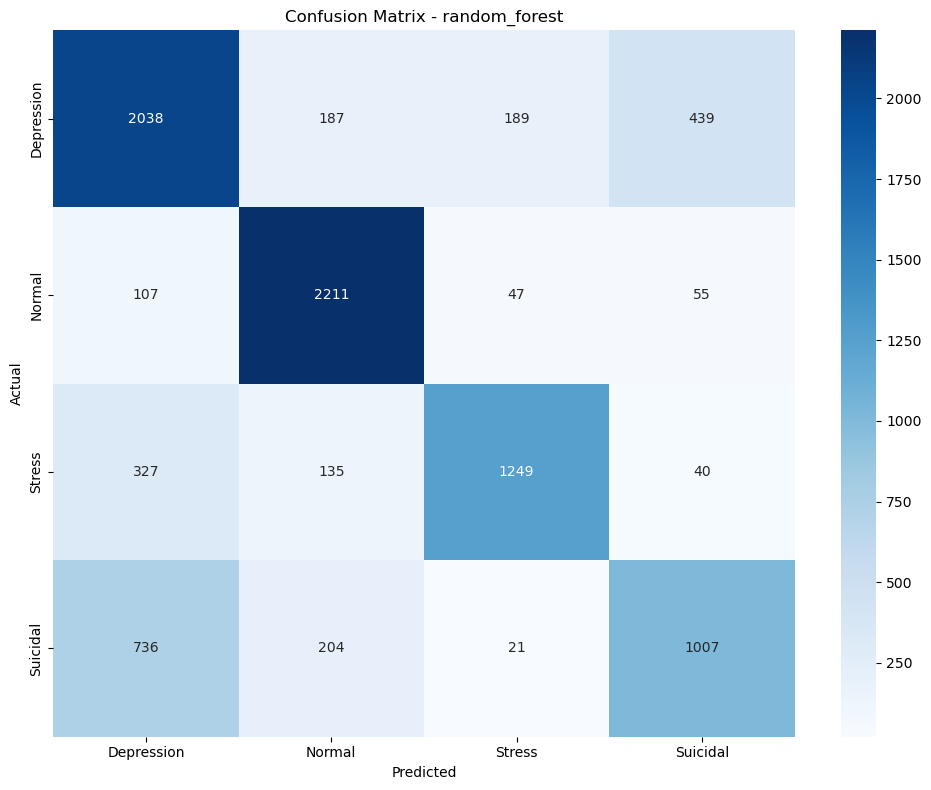

Saved: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_20251202_020849_confusion_matrix.png


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

cm = np.array(result['metrics']['confusion_matrix'])
labels = result['metrics']['confusion_matrix_labels']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - {MODEL_TYPE}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

cm_path = os.path.join(OUTPUT_DIR, f'{job_id}_confusion_matrix.png')
plt.savefig(cm_path, dpi=150)
plt.show()
print(f'Saved: {cm_path}')

In [11]:
print('Per-class metrics:')
report = result['metrics']['classification_report']
for label in labels:
    if label in report:
        m = report[label]
        print(f"{label:20} P: {m['precision']:.3f}  R: {m['recall']:.3f}  F1: {m['f1-score']:.3f}  Support: {m['support']}")

Per-class metrics:
Depression           P: 0.635  R: 0.714  F1: 0.672  Support: 2853.0
Normal               P: 0.808  R: 0.914  F1: 0.857  Support: 2420.0
Stress               P: 0.829  R: 0.713  F1: 0.767  Support: 1751.0
Suicidal             P: 0.653  R: 0.512  F1: 0.574  Support: 1968.0


In [12]:
import json

results_path = os.path.join(OUTPUT_DIR, f'{job_id}_results.json')

save_results = {
    'job_id': job_id,
    'model_type': MODEL_TYPE,
    'model_path': result['model_path'],
    'config': config,
    'data': {
        'train_samples': len(X_train),
        'test_samples': len(X_test_fixed),
        'classes': list(set(y_train)),
    },
    'metrics': result['metrics'],
    'timestamp': timestamp,
}

with open(results_path, 'w') as f:
    json.dump(save_results, f, indent=2)

print(f'Saved: {results_path}')

Saved: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_20251202_020849_results.json


In [13]:
# Google colab does not have swifter installed
if IN_COLAB:
    !pip install swifter

## Test Inference

In [15]:
from ml_pipeline.inference.predictor import Predictor

test_texts = [
    "I feel so stressed and anxious about everything lately.",
    "Life is great, I'm feeling happy and content.",
    "I don't want to live anymore, everything is hopeless.",
    "I can't stop crying and I feel so empty inside.",
    "I am happy and stressed"
]

# Load predictor
predictor = Predictor(storage)
predictor.load(result['model_path'])

print('Sample predictions:')
print('=' * 70)

for text in test_texts:
    # Preprocess text first (same as training)
    processed = preprocessor._preprocess_single_text(text)

    # Get prediction
    pred = predictor.predict(processed)

    print(f'\nText: "{text}"')
    print('-' * 70)

    # Sort probabilities descending
    sorted_probs = sorted(pred['probabilities'].items(), key=lambda x: -x[1])

    for i, (label, prob) in enumerate(sorted_probs):
        if i == 0:
            print(f'  >>> {label:20} {prob*100:5.1f}% <<<')
        else:
            print(f'      {label:20} {prob*100:5.1f}%')

print('\n' + '=' * 70)

2025-12-02 02:09:12,354 - ml_pipeline.inference.predictor - INFO - Loaded model from /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_random_forest_20251202_020849.joblib


Sample predictions:

Text: "I feel so stressed and anxious about everything lately."
----------------------------------------------------------------------
  >>> Stress                71.0% <<<
      Normal                15.6%
      Depression            11.4%
      Suicidal               2.0%

Text: "Life is great, I'm feeling happy and content."
----------------------------------------------------------------------
  >>> Normal                58.0% <<<
      Suicidal              21.0%
      Depression            16.0%
      Stress                 5.0%

Text: "I don't want to live anymore, everything is hopeless."
----------------------------------------------------------------------
  >>> Suicidal              68.7% <<<
      Depression            21.0%
      Normal                10.3%
      Stress                 0.0%

Text: "I can't stop crying and I feel so empty inside."
----------------------------------------------------------------------
  >>> Normal                60.2% <<

## Summary

In [16]:
base_accuracy = result["metrics"]["accuracy"]

print('=' * 60)
print('TRAINING SUMMARY')
print('=' * 60)
print(f'Model:      {MODEL_TYPE}')
print(f'Job ID:     {job_id}')
print(f'Accuracy:   {base_accuracy:.4f}')
print(f'F1 Score:   {result["metrics"]["f1_score"]:.4f}')
print(f'Model Path: {result["model_path"]}')
print('=' * 60)
print(f'All outputs saved to: {OUTPUT_DIR}')

TRAINING SUMMARY
Model:      random_forest
Job ID:     random_forest_20251202_020849
Accuracy:   0.7234
F1 Score:   0.7191
Model Path: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_random_forest_20251202_020849.joblib
All outputs saved to: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment



## Incremental training (fine-tune existing model)

In [17]:
%%time
TRAINING_MODE = 'incremental'

# Option 1: Use model from previous full training in this session
# Option 2: Specify a path to any existing model
USE_PREVIOUS_RESULT = True  # Set to False to use CUSTOM_MODEL_PATH

CUSTOM_MODEL_PATH = str(OUTPUT_DIR / 'transformer_transformer_20251130_003457.pt')  # Your best model

if USE_PREVIOUS_RESULT and result:
    BASE_MODEL_PATH = result['model_path']
    base_accuracy = result['metrics']['accuracy']
    print(f"Using model from this session: {BASE_MODEL_PATH}")
else:
    BASE_MODEL_PATH = CUSTOM_MODEL_PATH
    # Load base model metrics for comparison
    checkpoint = storage.load_neural_model(BASE_MODEL_PATH)
    print(f"Using custom model: {BASE_MODEL_PATH}")
    print("Note: Run evaluation on base model first to get base_accuracy for comparison")
    base_accuracy = None  # Will need to evaluate separately

print(f"Base model: {BASE_MODEL_PATH}")

# Config for incremental
incremental_config = {
    'training_mode': 'incremental',
    'base_model_path': BASE_MODEL_PATH,
    'learning_rate': 1e-5,
    'epochs': 5,
    'patience': 3,
    'batch_size': 32,
    'max_seq_len': 256,
    'expand_vocab': True,
}

print(f'Training {MODEL_TYPE}...')

# Train incrementally, important to use fixed test data
result = trainer.train(
    model_name=MODEL_TYPE, # Set in the config
    data=(X_train_incremental, y_train_incremental, X_test_fixed, y_test_fixed),
    config=incremental_config,
    job_id=f'transformer_incremental_{timestamp}',
)

print('Training complete!')

2025-12-02 02:09:14,227 - ml_pipeline.training.trainer - INFO - Starting training for random_forest
2025-12-02 02:09:14,228 - ml_pipeline.training.trainer - INFO - Training on 3000 samples


Using model from this session: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_random_forest_20251202_020849.joblib
Base model: /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_random_forest_20251202_020849.joblib
Training random_forest...


2025-12-02 02:09:15,024 - ml_pipeline.training.trainer - INFO - Evaluating on 8992 samples
2025-12-02 02:09:15,911 - ml_pipeline.evaluation.evaluator - INFO - Top 10 features:
2025-12-02 02:09:16,113 - ml_pipeline.storage.handler - INFO - Saved sklearn model to /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_transformer_incremental_20251202_020849.joblib
2025-12-02 02:09:16,113 - ml_pipeline.training.trainer - INFO - Training complete. Accuracy: 0.6727


Training complete!
CPU times: user 6.73 s, sys: 61.3 ms, total: 6.79 s
Wall time: 1.89 s


### Run same tests again but after incremental train

In [18]:
test_texts = [
    "I feel so stressed and anxious about everything lately.",
    "Life is great, I'm feeling happy and content.",
    "I don't want to live anymore, everything is hopeless.",
    "I can't stop crying and I feel so empty inside.",
    "I am happy and stressed"
]

# Load predictor
predictor = Predictor(storage)
predictor.load(result['model_path'])

print('Sample predictions:')
print('=' * 70)

for text in test_texts:
    # Preprocess text first (same as training)
    processed = preprocessor._preprocess_single_text(text)

    # Get prediction
    pred = predictor.predict(processed)

    print(f'\nText: "{text}"')
    print('-' * 70)

    # Sort probabilities descending
    sorted_probs = sorted(pred['probabilities'].items(), key=lambda x: -x[1])

    for i, (label, prob) in enumerate(sorted_probs):
        if i == 0:
            print(f'  >>> {label:20} {prob*100:5.1f}% <<<')
        else:
            print(f'      {label:20} {prob*100:5.1f}%')

print('\n' + '=' * 70)

2025-12-02 02:09:16,208 - ml_pipeline.inference.predictor - INFO - Loaded model from /home/mbx/Documents/projects/gitlab/sentio/ml_pipeline/sentio_results/increment/random_forest_transformer_incremental_20251202_020849.joblib


Sample predictions:

Text: "I feel so stressed and anxious about everything lately."
----------------------------------------------------------------------
  >>> Stress                64.0% <<<
      Normal                21.0%
      Suicidal              12.0%
      Depression             3.0%

Text: "Life is great, I'm feeling happy and content."
----------------------------------------------------------------------
  >>> Normal                47.0% <<<
      Suicidal              28.0%
      Depression            15.0%
      Stress                10.0%

Text: "I don't want to live anymore, everything is hopeless."
----------------------------------------------------------------------
  >>> Suicidal              45.0% <<<
      Normal                36.0%
      Depression            16.0%
      Stress                 3.0%

Text: "I can't stop crying and I feel so empty inside."
----------------------------------------------------------------------
  >>> Normal                58.0% <<

In [19]:
print(f"Incremental model accuracy: {result['metrics']['accuracy']:.4f}")
print(f"Incremental model F1: {result['metrics']['f1_score']:.4f}")

Incremental model accuracy: 0.6727
Incremental model F1: 0.6616


In [20]:
new_accuracy = result['metrics']['accuracy']

if base_accuracy is not None:
    print(f"Base model:        {base_accuracy:.4f}")
    print(f"Incremental model: {new_accuracy:.4f}")
    print(f"Change:            {new_accuracy - base_accuracy:+.4f}")

    if new_accuracy > base_accuracy:
        print("Model improved!")
    else:
        print(f"Model did not improve with adding {len(X_train_incremental)} rows of data")
else:
    print(f"Incremental model: {new_accuracy:.4f}")
    print("(Base accuracy not available - evaluate base model separately to compare)")

Base model:        0.7234
Incremental model: 0.6727
Change:            -0.0507
Model did not improve with adding 3000 rows of data
